# Product level Impact of 3.2 Beer in Kansas

In [1]:
# packages used
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab as pl
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

## ON PREMISE ANALYSIS

### Load Store Data

In [2]:
#load the All stores in Kansas
All_Stores_Kansas = pd.read_csv('AllStoresKansas.csv')
All_Stores_Kansas = All_Stores_Kansas.rename(columns = {'WJXBFS1':'PROD_DEPLETION'})
All_Stores_Kansas.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,103946193,CORONA EX 18PK BT,OFF,84.750
1,101537249,CORONA EX 3.2 24OZ BT,OFF,32.000
2,107443744,PACIFICO 6PK BT,OFF,10.000
3,200572989,CORONA EX 3.2 6PK BT,OFF,22.000
4,101476216,CORONITA 7OZ 6PK BT,OFF,153.418


In [3]:
#clean data
All_Stores_Kansas['RTL_STORE_CD'] = All_Stores_Kansas['RTL_STORE_CD'].astype(str)
#remove NA Depletion 
All_Stores_Kansas = All_Stores_Kansas.loc[All_Stores_Kansas['PROD_DEPLETION'].notnull(),:]

#remove Negative Depletion
All_Stores_Kansas = All_Stores_Kansas.loc[All_Stores_Kansas['PROD_DEPLETION'] > 0.0,:] 
All_Stores_Kansas.shape

(33000, 4)

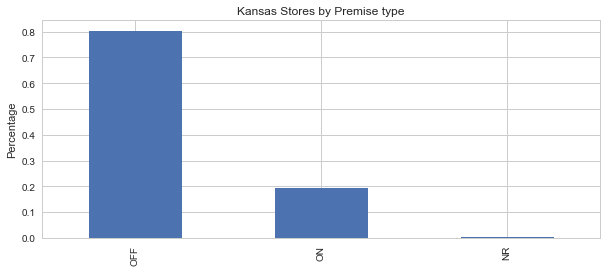

In [4]:
# Kansas Stores by Premise type
premise_type = All_Stores_Kansas.loc[:,'RTL_PREMISE_TYPE_CD']
premise_type = premise_type.value_counts()/len(premise_type)
ax = premise_type.plot.bar(figsize=(10,4), title = 'Kansas Stores by Premise type')
ax.set_ylabel("Percentage");

### Load Product Data for On-Premise

In [5]:
LowPoint = pd.read_csv('KansasLowPointProducts.csv')
LowPointOn = LowPoint.loc[LowPoint['RTL_PREMISE_TYPE_CD'] == 'ON', :].reset_index(drop = True)
Top5LowPointOn = LowPointOn.head(10)['ITEM_MASTER_SKU_DSC']
Top5LowPointOn

0       CORONA EX 3.2 6PK BT
1      CORONA EX 3.2 12PK BT
2          CORONA LT 18PK BT
3      MODELO ESP 3.2 6PK BT
4     MODELO ESP 3.2 12PK BT
5    CORONA LIGHT 1/2 BL KEG
6    MODELO ESP 3.2 12PK CAN
7    MODELO ESP 3.2 24OZ CAN
8          CORONA LT 24PK BT
9      CORONA EX 3.2 24OZ BT
Name: ITEM_MASTER_SKU_DSC, dtype: object

In [6]:
#select top 5 products that are comparable:
Top5LowPointOn = Top5LowPointOn[[0,1,3,4,6]]
#put the products and their pairs into datafame
Top5_LowPoint_On_Pairs_DF = pd.DataFrame(Top5LowPointOn).reset_index(drop=True)
Top5_LowPoint_On_Pairs_DF['PAIRS'] = ['CORONA EX 6PK BT', 'CORONA EX 12PK BT', 'MODELO ESP 6PK BT', 'MODELO ESP 12PK BT', 'MODELO ESP 12PK CAN']
Top5_LowPoint_On_Pairs_DF

,ITEM_MASTER_SKU_DSC,PAIRS
0,CORONA EX 3.2 6PK BT,CORONA EX 6PK BT
1,CORONA EX 3.2 12PK BT,CORONA EX 12PK BT
2,MODELO ESP 3.2 6PK BT,MODELO ESP 6PK BT
3,MODELO ESP 3.2 12PK BT,MODELO ESP 12PK BT
4,MODELO ESP 3.2 12PK CAN,MODELO ESP 12PK CAN


In [7]:
BeerList_On = list(Top5_LowPoint_On_Pairs_DF['ITEM_MASTER_SKU_DSC']) + list(Top5_LowPoint_On_Pairs_DF['PAIRS'])
BeerList_On

['CORONA EX 3.2 6PK BT',
 'CORONA EX 3.2 12PK BT',
 'MODELO ESP 3.2 6PK BT',
 'MODELO ESP 3.2 12PK BT',
 'MODELO ESP 3.2 12PK CAN',
 'CORONA EX 6PK BT',
 'CORONA EX 12PK BT',
 'MODELO ESP 6PK BT',
 'MODELO ESP 12PK BT',
 'MODELO ESP 12PK CAN']

### Analysis for On-Premise

In [8]:
#Subset On-premise stores 
Top5_On_pairs_stores = All_Stores_Kansas.loc[All_Stores_Kansas['RTL_PREMISE_TYPE_CD'] == 'ON', :]

#Subset On-premise stoers that sell top 5 pairs of beer (10 products)
Top5_On_pairs_stores= Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(BeerList_On)].reset_index(drop=True)

Top5_On_pairs_stores.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,101733532,MODELO ESP 12PK BT,ON,14.0
1,301616936,MODELO ESP 6PK BT,ON,16.0
2,101733587,CORONA EX 12PK BT,ON,7.0
3,103639684,CORONA EX 12PK BT,ON,3.0
4,201725170,MODELO ESP 6PK BT,ON,17.0


In [9]:
len(Top5_On_pairs_stores)

2466

In [10]:
Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].unique()

array(['MODELO ESP 12PK BT', 'MODELO ESP 6PK BT', 'CORONA EX 12PK BT',
       'MODELO ESP 3.2 12PK BT', 'CORONA EX 3.2 12PK BT',
       'MODELO ESP 3.2 6PK BT', 'CORONA EX 3.2 6PK BT', 'CORONA EX 6PK BT',
       'MODELO ESP 3.2 12PK CAN', 'MODELO ESP 12PK CAN'], dtype=object)

In [11]:
#create a graph_DF for explanatory analysis.
graph_DF = Top5_On_pairs_stores
graph_DF['Product'] = graph_DF['ITEM_MASTER_SKU_DSC']
for index in range(len(graph_DF['Product'])):
    if '3.2 ' in graph_DF.loc[index, 'Product']:
        graph_DF.loc[index, 'Product'] = graph_DF.loc[index, 'Product'].replace('3.2 ','')
graph_DF['is32'] = graph_DF['ITEM_MASTER_SKU_DSC'] != graph_DF['Product']        

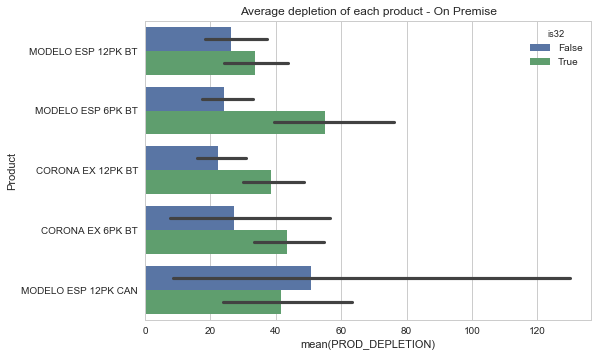

In [12]:
#plot Average depletion of each product for On-premise
plt.title("Average depletion of each product - On Premise")
sns.barplot(x='PROD_DEPLETION', y="Product", hue="is32", data=graph_DF);

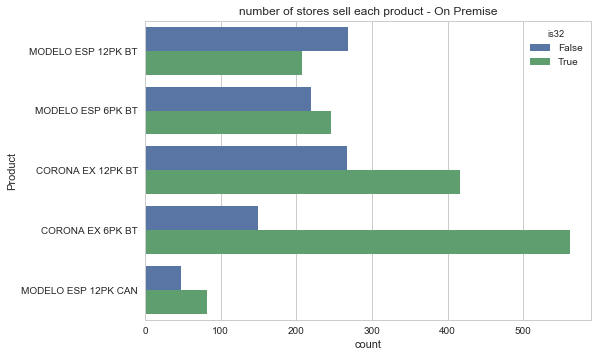

In [13]:
#plot number of stores sell each product for On-premise
plt.title("number of stores sell each product - On Premise")
#sns.barplot(x=graph_DF['Product'].value_counts(),y= graph_DF['Product'], hue=graph_DF["is32"]);
graph = sns.countplot(y='Product', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['Product'].unique(), rotation=0);

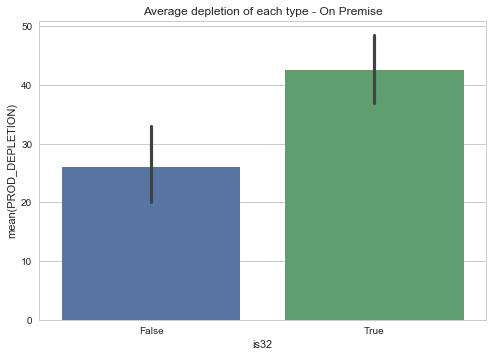

In [14]:
# Average depletion for 3.2 and Non 3.2 products
plt.title("Average depletion of each type - On Premise")
sns.barplot(x='is32', y = 'PROD_DEPLETION', data=graph_DF);

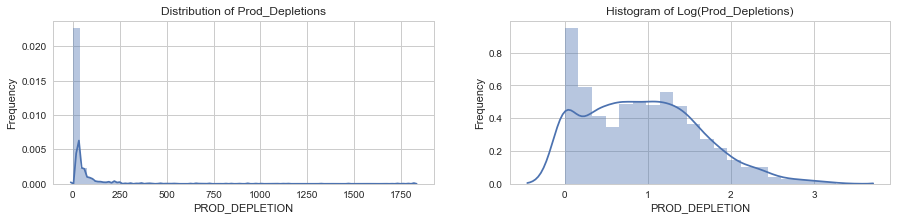

In [15]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title('Distribution of Prod_Depletions')
sns.distplot(Top5_On_pairs_stores['PROD_DEPLETION'])
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.title('Histogram of Log(Prod_Depletions)')
sns.distplot(np.log10(Top5_On_pairs_stores['PROD_DEPLETION'].values))
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency');

## Regression Analysis on Five products for On-premise

### Load Cluster data and Merge 

In [16]:
StoresON = pd.read_csv('KansasONStores.csv', dtype = str)
del StoresON['Unnamed: 0']
StoresON['STORE_CD'] = StoresON['STORE_CD'].astype(str)
StoresON.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,...,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY,CLUSTER,RTL_STORE_CD,BEERTYPE
0,101914477,4.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,False,False,0.9009,0.0147,0.0065,...,0.0676,0.0624,0.0578,0.0648,0.046,0.0433,0.0011243730625538555,0,NaN,LowPoint
1,103707016,36.5,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,VARIED MENU,True,True,0.7495,0.0968,0.0631,...,0.0641,0.0622,0.0644,0.0676,0.0435,0.0318,0.012368103688092408,1,103707016,NonLowPoint
2,101930302,5.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,False,False,0.8433,0.0436,0.008,...,0.0561,0.0551,0.0613,0.0715,0.0577,0.0472,0.0014703340048781185,0,NaN,LowPoint
3,101943225,2.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,True,True,0.9453,0.0098,0.0035,...,0.0527,0.0614,0.0694,0.0696,0.0473,0.0435,0.00043245117790532896,1,NaN,LowPoint
4,107487797,117.97200000000001,BAR/NIGHTCLUB,SPORTS BAR,AMERICAN,True,True,0.7901,0.0996,0.0231,...,0.0575,0.0688,0.0657,0.0663,0.0462,0.0314,0.04055423358113478,1,107487797,NonLowPoint


In [17]:
#Inner join StoreON Data with Top5_On_pairs_stores for regression
RegressionDataON = pd.merge(StoresON, Top5_On_pairs_stores, left_on='STORE_CD', right_on="RTL_STORE_CD", how="inner")
RegressionDataON.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,...,NORM_L12M_TY_QTY,CLUSTER,RTL_STORE_CD_x,BEERTYPE,RTL_STORE_CD_y,ITEM_MASTER_SKU_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION,Product,is32
0,101914477,4.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,False,False,0.9009,0.0147,0.0065,...,0.0011243730625538555,0,NaN,LowPoint,101914477,CORONA EX 3.2 6PK BT,ON,17.0,CORONA EX 6PK BT,True
1,103707016,36.5,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,VARIED MENU,True,True,0.7495,0.0968,0.0631,...,0.012368103688092408,1,103707016,NonLowPoint,103707016,CORONA EX 6PK BT,ON,3.0,CORONA EX 6PK BT,False
2,101930302,5.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,False,False,0.8433,0.0436,0.008,...,0.0014703340048781185,0,NaN,LowPoint,101930302,CORONA EX 3.2 12PK BT,ON,16.0,CORONA EX 12PK BT,True
3,101930302,5.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,False,False,0.8433,0.0436,0.008,...,0.0014703340048781185,0,NaN,LowPoint,101930302,CORONA EX 3.2 6PK BT,ON,13.0,CORONA EX 6PK BT,True
4,101943225,2.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,True,True,0.9453,0.0098,0.0035,...,0.00043245117790532896,1,NaN,LowPoint,101943225,MODELO ESP 3.2 12PK BT,ON,1.0,MODELO ESP 12PK BT,True


In [18]:
len(RegressionDataON)

1418

In [19]:
#pair1: 
subset1 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[0, :]))].reset_index(drop=True)
Regression_ON_pair1_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset1)
print(Regression_ON_pair1_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.200
Model:                                OLS   Adj. R-squared:                  0.190
Method:                     Least Squares   F-statistic:                     21.44
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           8.30e-16
Time:                            12:00:11   Log-Likelihood:                -619.30
No. Observations:                     349   AIC:                             1249.
Df Residuals:                         344   BIC:                             1268.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

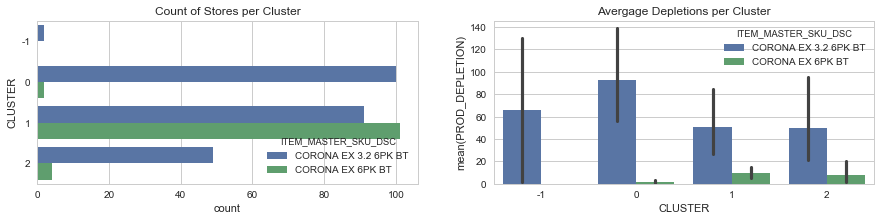

In [20]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset1);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset1);

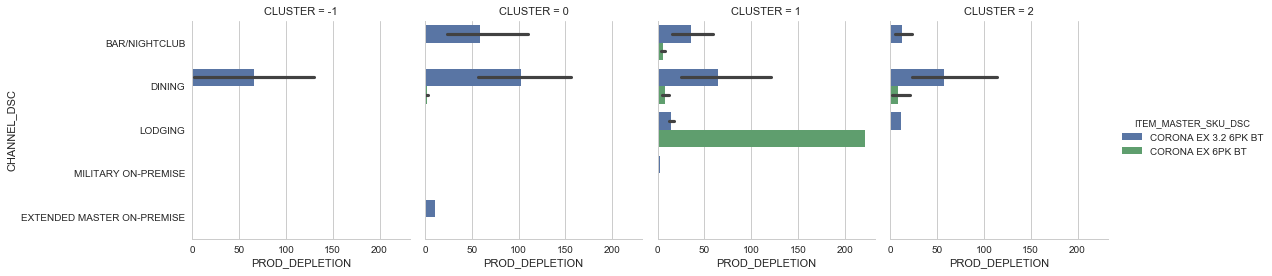

In [21]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset1, kind="bar");

In [22]:
#pair 2: 
subset2 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[1, :]))].reset_index(drop=True)
Regression_ON_pair2_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(CLUSTER)', data= subset2)
print(Regression_ON_pair2_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.020
Model:                                OLS   Adj. R-squared:                  0.011
Method:                     Least Squares   F-statistic:                     2.108
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):             0.0790
Time:                            12:00:13   Log-Likelihood:                -740.93
No. Observations:                     410   AIC:                             1492.
Df Residuals:                         405   BIC:                             1512.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

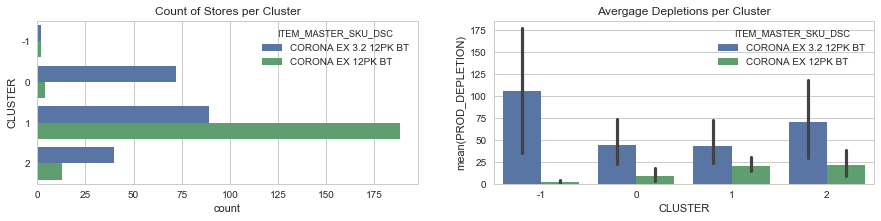

In [23]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset2);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset2);

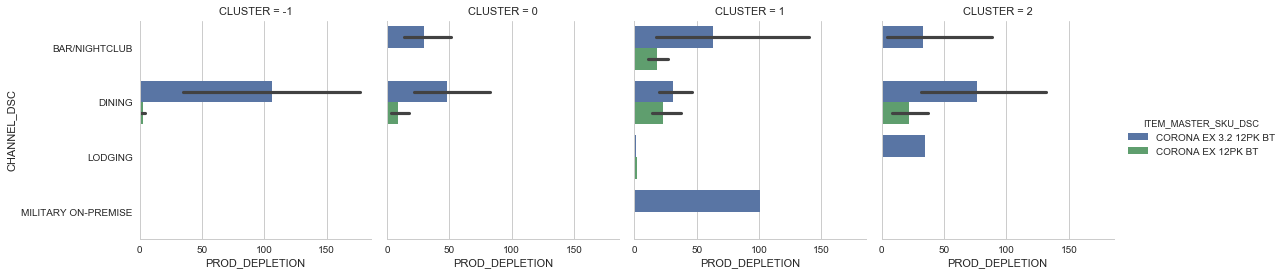

In [24]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset2, kind="bar");

In [25]:
#pair 3: 
subset3 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[2, :]))].reset_index(drop=True)
Regression_ON_pair3_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(CLUSTER)', data= subset3)
print(Regression_ON_pair3_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.076
Model:                                OLS   Adj. R-squared:                  0.062
Method:                     Least Squares   F-statistic:                     5.480
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           0.000296
Time:                            12:00:14   Log-Likelihood:                -489.72
No. Observations:                     272   AIC:                             989.4
Df Residuals:                         267   BIC:                             1007.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

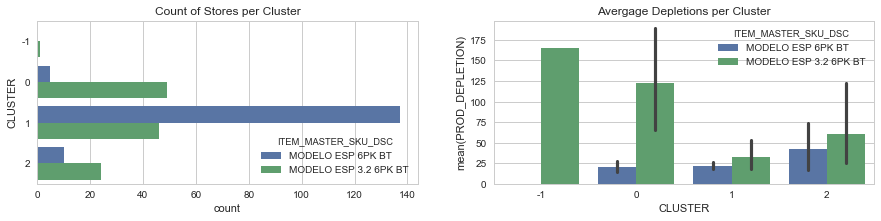

In [26]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset3);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset3);

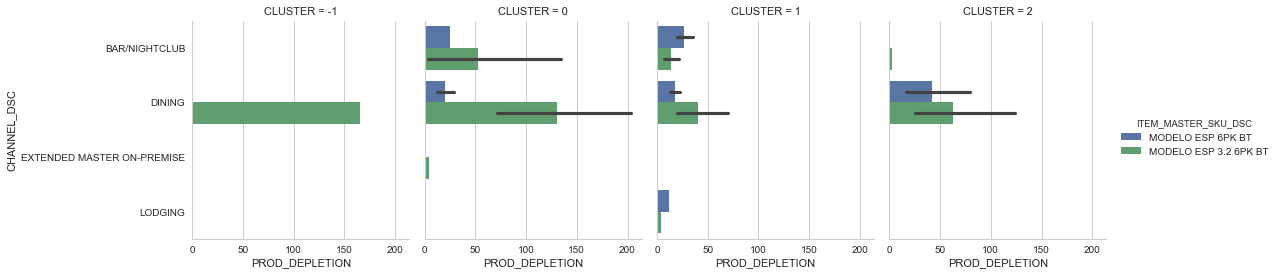

In [27]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset3, kind="bar");

In [28]:
#pair 4 
subset4 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[3, :]))].reset_index(drop=True)
Regression_ON_pair4_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(CLUSTER)', data= subset4)
print(Regression_ON_pair4_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.014
Model:                                OLS   Adj. R-squared:                  0.001
Method:                     Least Squares   F-statistic:                     1.084
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):              0.364
Time:                            12:00:16   Log-Likelihood:                -594.88
No. Observations:                     317   AIC:                             1200.
Df Residuals:                         312   BIC:                             1219.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

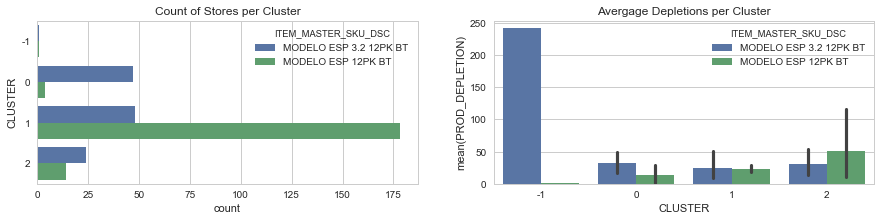

In [29]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset4);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset4);

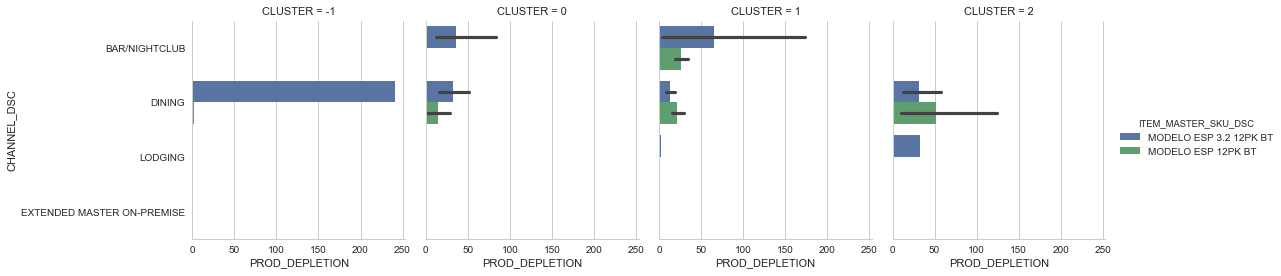

In [30]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset4, kind="bar");

In [31]:
#pair 5 
subset5 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[4, :]))].reset_index(drop=True)
Regression_ON_pair5_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(CLUSTER)', data= subset5)
print(Regression_ON_pair5_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.037
Model:                                OLS   Adj. R-squared:                 -0.023
Method:                     Least Squares   F-statistic:                    0.6192
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):              0.650
Time:                            12:00:18   Log-Likelihood:                -133.31
No. Observations:                      70   AIC:                             276.6
Df Residuals:                          65   BIC:                             287.9
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

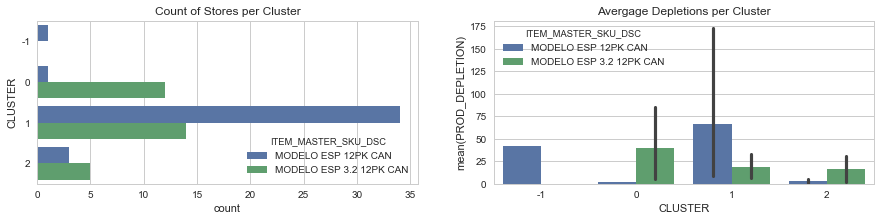

In [32]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset5);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset5);

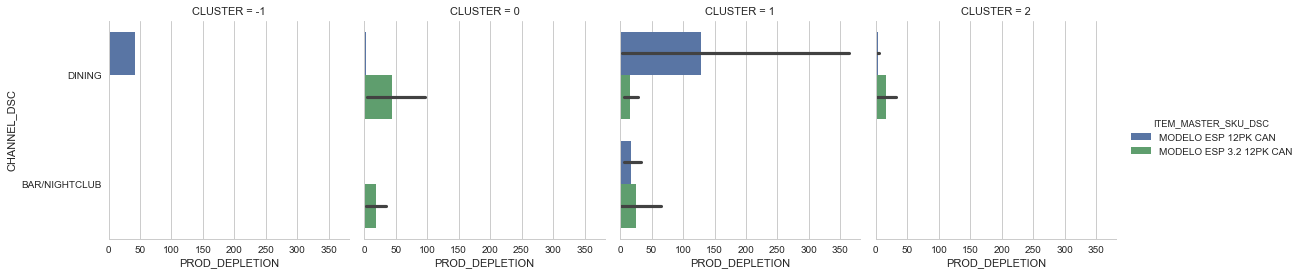

In [33]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset5, kind="bar");

## OFF PREMISE ANALYSIS

### Load Product Data for Off-Premise

In [34]:
#load the product data for Off Premise 
LowPointOff = LowPoint.loc[LowPoint['RTL_PREMISE_TYPE_CD'] == 'OFF', :].reset_index(drop = True)
Top5LowPointOff = LowPointOff.head(10)['ITEM_MASTER_SKU_DSC']
Top5LowPointOff

0      CORONA EX 3.2 12PK BT
1          CORONA LT 12PK BT
2    MODELO ESP 3.2 12PK CAN
3       CORONA EX 3.2 6PK BT
4    MODELO CHELADA 24OZ CAN
5      CORONA EX 3.2 18PK BT
6           CORONA LT 6PK BT
7     MODELO ESP 3.2 12PK BT
8    MODELO ESP 3.2 18PK CAN
9      MODELO ESP 3.2 6PK BT
Name: ITEM_MASTER_SKU_DSC, dtype: object

In [35]:
#select top 5 products that are comparable:
Top5LowPointOff = Top5LowPointOff[[0,2,3,5,7]]
#put the products and their pairs into datafame
Top5_LowPoint_Off_Pairs_DF = pd.DataFrame(Top5LowPointOff).reset_index(drop=True)
Top5_LowPoint_Off_Pairs_DF['PAIRS'] = ['CORONA EX 12PK BT', 'MODELO ESP 12PK CAN', 'CORONA EX 6PK BT', 'CORONA EX 18PK BT', 'MODELO ESP 12PK BT']
Top5_LowPoint_Off_Pairs_DF

,ITEM_MASTER_SKU_DSC,PAIRS
0,CORONA EX 3.2 12PK BT,CORONA EX 12PK BT
1,MODELO ESP 3.2 12PK CAN,MODELO ESP 12PK CAN
2,CORONA EX 3.2 6PK BT,CORONA EX 6PK BT
3,CORONA EX 3.2 18PK BT,CORONA EX 18PK BT
4,MODELO ESP 3.2 12PK BT,MODELO ESP 12PK BT


In [36]:
BeerList_Off = list(Top5_LowPoint_Off_Pairs_DF['ITEM_MASTER_SKU_DSC']) + list(Top5_LowPoint_Off_Pairs_DF['PAIRS'])
BeerList_Off

['CORONA EX 3.2 12PK BT',
 'MODELO ESP 3.2 12PK CAN',
 'CORONA EX 3.2 6PK BT',
 'CORONA EX 3.2 18PK BT',
 'MODELO ESP 3.2 12PK BT',
 'CORONA EX 12PK BT',
 'MODELO ESP 12PK CAN',
 'CORONA EX 6PK BT',
 'CORONA EX 18PK BT',
 'MODELO ESP 12PK BT']

### Analysis for Off-Premise

In [37]:
#Subset Off-premise stores 
Top5_Off_pairs_stores = All_Stores_Kansas.loc[All_Stores_Kansas['RTL_PREMISE_TYPE_CD'] == 'OFF', :]

#Subset Off-premise stoers that sell top 5 pairs of beer (10 products)
Top5_Off_pairs_stores= Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(BeerList_Off)].reset_index(drop=True)

Top5_Off_pairs_stores.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,103946193,CORONA EX 18PK BT,OFF,84.7500
1,200572989,CORONA EX 3.2 6PK BT,OFF,22.0000
2,107354744,CORONA EX 18PK BT,OFF,353.2500
3,101967580,CORONA EX 3.2 6PK BT,OFF,197.0000
4,100326479,CORONA EX 3.2 6PK BT,OFF,157.7917


In [38]:
len(Top5_Off_pairs_stores)

7842

In [39]:
Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].unique()

array(['CORONA EX 18PK BT', 'CORONA EX 3.2 6PK BT', 'MODELO ESP 12PK BT',
       'CORONA EX 3.2 12PK BT', 'CORONA EX 12PK BT', 'MODELO ESP 12PK CAN',
       'CORONA EX 6PK BT', 'MODELO ESP 3.2 12PK BT',
       'MODELO ESP 3.2 12PK CAN', 'CORONA EX 3.2 18PK BT'], dtype=object)

In [40]:
#create a graph_DF for explanatory analysis.
graph_DF = Top5_Off_pairs_stores
graph_DF['Product'] = graph_DF['ITEM_MASTER_SKU_DSC']
for index in range(len(graph_DF['Product'])):
    if '3.2 ' in graph_DF.loc[index, 'Product']:
        graph_DF.loc[index, 'Product'] = graph_DF.loc[index, 'Product'].replace('3.2 ','')
graph_DF['is32'] = graph_DF['ITEM_MASTER_SKU_DSC'] != graph_DF['Product']  

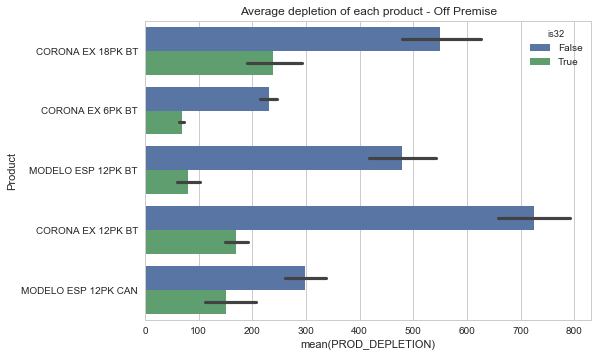

In [41]:
#plot Average depletion of each product for Off-premise
plt.title("Average depletion of each product - Off Premise")
sns.barplot(x='PROD_DEPLETION', y="Product", hue="is32", data=graph_DF);

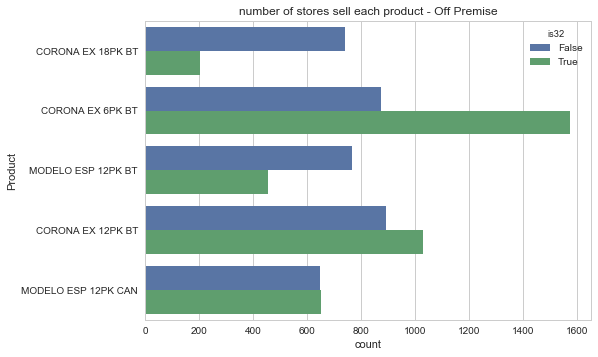

In [42]:
#plot number of stores sell each product for Off-premise
plt.title("number of stores sell each product - Off Premise")
graph = sns.countplot(y='Product', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['Product'].unique(), rotation=0);

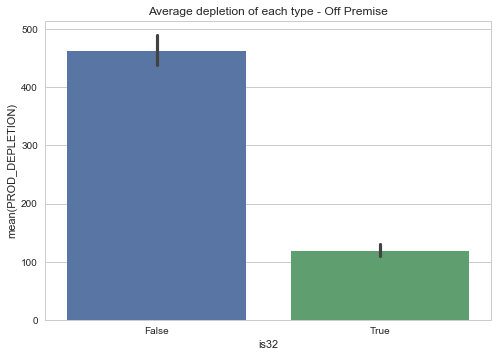

In [43]:
# Average depletion for 3.2 and Non 3.2 products
plt.title("Average depletion of each type - Off Premise")
sns.barplot(x='is32', y = 'PROD_DEPLETION', data=graph_DF);

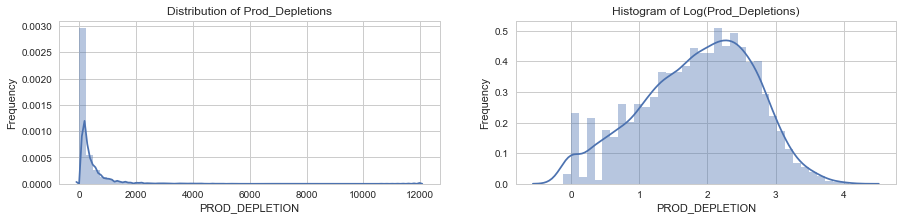

In [44]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title('Distribution of Prod_Depletions')
sns.distplot(Top5_Off_pairs_stores['PROD_DEPLETION'])
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.title('Histogram of Log(Prod_Depletions)')
sns.distplot(np.log10(Top5_Off_pairs_stores['PROD_DEPLETION'].values))
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency');

### Regression Analysis on Five products for Off-premise

### Load clustering data and Merge 

In [45]:
StoresOFF = pd.read_csv('KansasOFFStores.csv')
del StoresOFF['Unnamed: 0']
StoresOFF['STORE_CD'] = StoresOFF['STORE_CD'].astype(str)
StoresOFF.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,...,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY,CLUSTER,RTL_STORE_CD,BEERTYPE
0,107027552,74.5000,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9437,0.0103,0.0081,0.0195,...,0.0486,0.0518,0.0589,0.0753,0.0581,0.0576,0.002474,1,107027552.0,NonLowPoint
1,201650423,311.2502,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.8233,0.0051,0.0065,0.1577,...,0.0463,0.0540,0.0624,0.0649,0.0459,0.0381,0.010442,1,201650423.0,NonLowPoint
2,100766228,614.7500,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.7785,0.0523,0.0719,0.0742,...,0.0854,0.0565,0.0429,0.0522,0.0372,0.0258,0.020657,1,100766228.0,NonLowPoint
3,100558459,41.0000,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,False,False,0.6504,0.1406,0.0332,0.1328,...,0.0823,0.0514,0.0386,0.0413,0.0278,0.0231,0.001346,0,NaN,LowPoint
4,101633764,125.2500,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9537,0.0015,0.0010,0.0150,...,0.0536,0.0463,0.0577,0.0840,0.0638,0.0577,0.004182,1,101633764.0,NonLowPoint


In [46]:
#Inner join StoreON Data with Top5_On_pairs_stores for regression
RegressionDataOFF = pd.merge(StoresOFF, Top5_Off_pairs_stores, left_on='STORE_CD', right_on="RTL_STORE_CD", how="inner")
RegressionDataOFF.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,...,NORM_L12M_TY_QTY,CLUSTER,RTL_STORE_CD_x,BEERTYPE,RTL_STORE_CD_y,ITEM_MASTER_SKU_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION,Product,is32
0,107027552,74.5000,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9437,0.0103,0.0081,0.0195,...,0.002474,1,107027552.0,NonLowPoint,107027552,MODELO ESP 12PK CAN,OFF,2.0,MODELO ESP 12PK CAN,False
1,107027552,74.5000,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9437,0.0103,0.0081,0.0195,...,0.002474,1,107027552.0,NonLowPoint,107027552,CORONA EX 6PK BT,OFF,51.0,CORONA EX 6PK BT,False
2,107027552,74.5000,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9437,0.0103,0.0081,0.0195,...,0.002474,1,107027552.0,NonLowPoint,107027552,CORONA EX 12PK BT,OFF,123.0,CORONA EX 12PK BT,False
3,107027552,74.5000,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9437,0.0103,0.0081,0.0195,...,0.002474,1,107027552.0,NonLowPoint,107027552,CORONA EX 18PK BT,OFF,6.0,CORONA EX 18PK BT,False
4,201650423,311.2502,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.8233,0.0051,0.0065,0.1577,...,0.010442,1,201650423.0,NonLowPoint,201650423,CORONA EX 6PK BT,OFF,22.0,CORONA EX 6PK BT,False


In [47]:
len(RegressionDataOFF)

6297

### Regression controlling for Cluster

In [48]:
#pair1: 
subset1 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[0, :]))].reset_index(drop=True)
Regression_Off_pair1_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset1)
print(Regression_Off_pair1_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.280
Model:                                OLS   Adj. R-squared:                  0.279
Method:                     Least Squares   F-statistic:                     295.4
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):          4.25e-109
Time:                            12:00:25   Log-Likelihood:                -2839.3
No. Observations:                    1522   AIC:                             5685.
Df Residuals:                        1519   BIC:                             5700.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

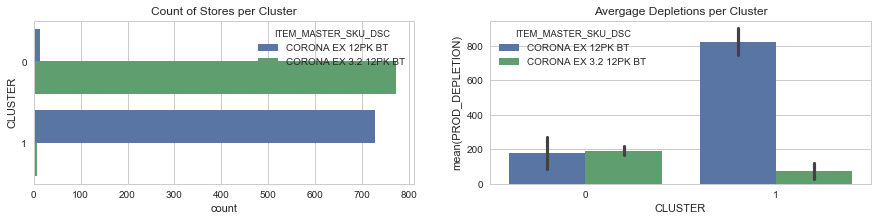

In [49]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset1);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset1);

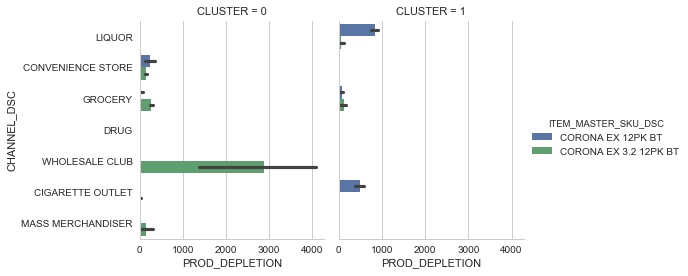

In [50]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset1, kind="bar");

In [51]:
#pair2:
subset2 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[1, :]))].reset_index(drop=True)
Regression_Off_pair2_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset2)
print(Regression_Off_pair2_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.048
Model:                                OLS   Adj. R-squared:                  0.046
Method:                     Least Squares   F-statistic:                     26.69
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           4.88e-12
Time:                            12:00:26   Log-Likelihood:                -2231.3
No. Observations:                    1069   AIC:                             4469.
Df Residuals:                        1066   BIC:                             4484.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

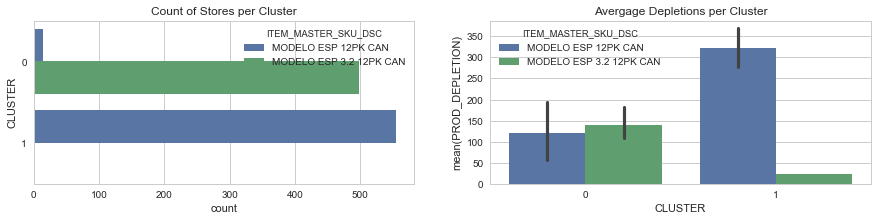

In [52]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset2);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset2);

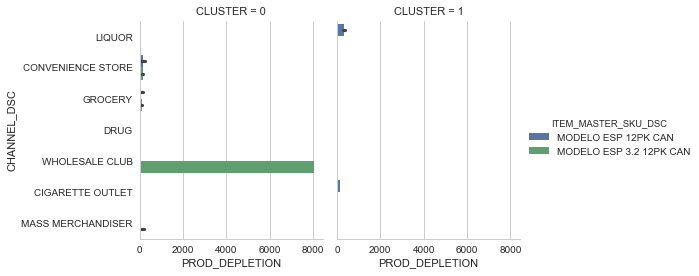

In [53]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset2, kind="bar");

In [54]:
#pair3: 
subset3 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[2, :]))].reset_index(drop=True)
Regression_Off_pair3_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset3)
print(Regression_Off_pair3_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.176
Model:                                OLS   Adj. R-squared:                  0.175
Method:                     Least Squares   F-statistic:                     199.0
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           4.32e-79
Time:                            12:00:27   Log-Likelihood:                -3129.2
No. Observations:                    1871   AIC:                             6264.
Df Residuals:                        1868   BIC:                             6281.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

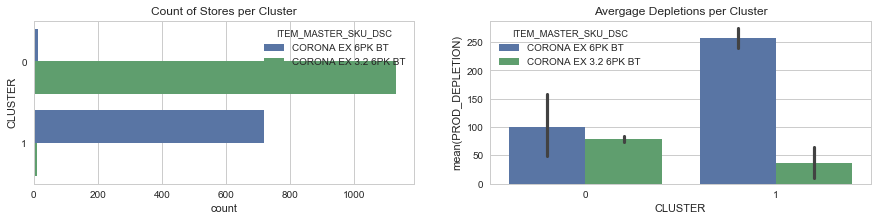

In [55]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset3);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset3);

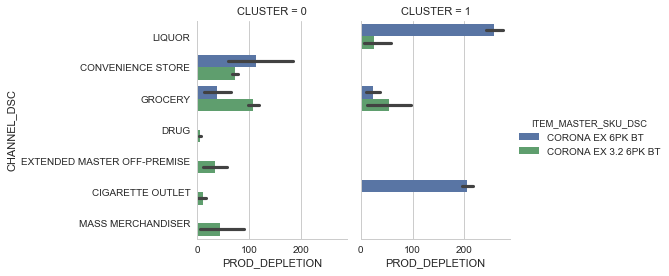

In [56]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset3, kind="bar");

In [57]:
#pair4: 
subset4 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[3, :]))].reset_index(drop=True)
Regression_Off_pair4_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset4)
print(Regression_Off_pair4_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.037
Model:                                OLS   Adj. R-squared:                  0.035
Method:                     Least Squares   F-statistic:                     15.35
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           2.87e-07
Time:                            12:00:29   Log-Likelihood:                -1697.2
No. Observations:                     801   AIC:                             3400.
Df Residuals:                         798   BIC:                             3414.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

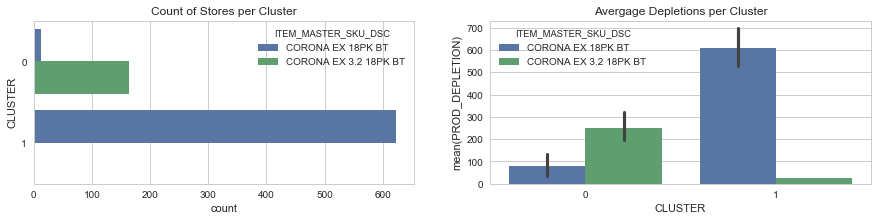

In [58]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset4);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset4);

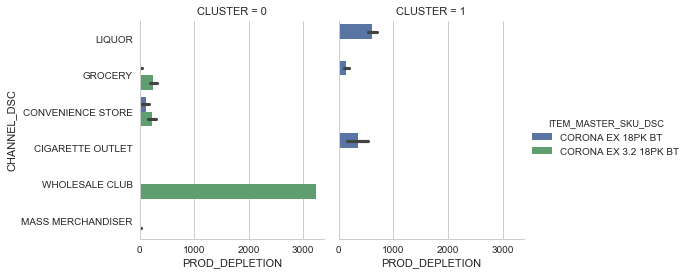

In [59]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset4, kind="bar");

In [60]:
#pair5: 
subset5 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[4, :]))].reset_index(drop=True)
Regression_Off_pair5_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset5)
print(Regression_Off_pair5_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.274
Model:                                OLS   Adj. R-squared:                  0.272
Method:                     Least Squares   F-statistic:                     194.4
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           2.33e-72
Time:                            12:00:31   Log-Likelihood:                -2042.5
No. Observations:                    1034   AIC:                             4091.
Df Residuals:                        1031   BIC:                             4106.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

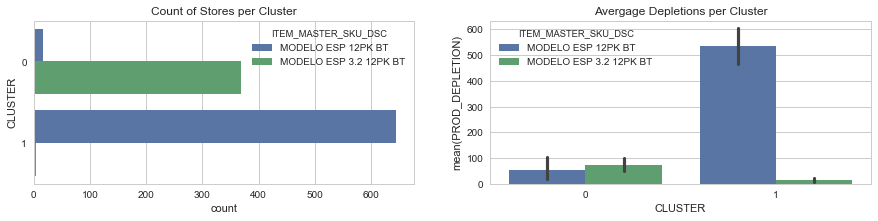

In [61]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset5);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset5);

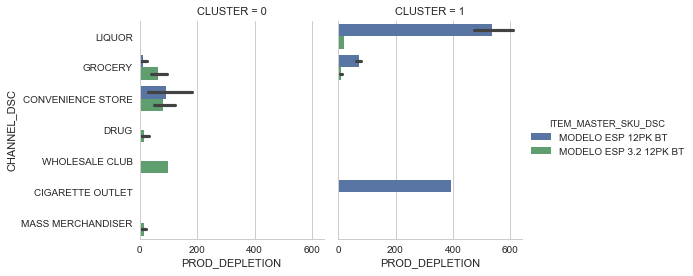

In [62]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset5, kind="bar");